In [ ]:
'''
TODO:
1. Найти и удалить выбросы
2. Нормализовать значения

PROBLEMS:
1. Наличие освещения -> bool/OHE? Или int, так как есть градация в виде сумерек? 
2. Схемы - это, конечно, интересно, но что с ними делать?
3. Severity -> int?
4. Время перевести в минуты?
5. нужны ли координаты и регион?

Границы СПб:
            from        to
latitude    59.63       60.24
longitude   29.42       30.76
'''

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from io import StringIO
from csv import writer
from IPython.display import display, HTML
from sklearn.preprocessing import Normalizer

In [4]:
# функция для преобразования кода съемы в HTML-код изображения на сервере сайта dtp-stat.ru

def path_to_image_html(path):
    return '<img src="https://dtp-stat.ru/static/scheme/'+ path + '.png">'

In [5]:
# функция для подготовки One-Hot кодирования столбца, в котором данные имеют вид списков
# возвращает набор присутствующих значений и DataFrame-объект закодированной таблицы 

def one_hot_prepare(datacol):      
    ohe_cols = []
    for value in datacol.values:
        for i in range(len(value)):
            if value[i] not in ohe_cols:
                ohe_cols.append(value[i])
                
    res = dict(zip(ohe_cols, [[None]*len(datacol) for _ in ohe_cols]))
    
    for i, value in enumerate(datacol):
        for col in ohe_cols:
            if col in value:
                res[col][i] = 1
            else:
                res[col][i] = 0      
    return ohe_cols, res
    

In [6]:
# функция для осуществления One-Hot кодирования указанных столбцов в заданной таблице

def one_hot_encoding(data, columns):
    for column in columns:
        ohe_headers, ohe_data = one_hot_prepare(data[column])
        for header in ohe_headers:
           data[header] = ohe_data[header]
        data = data.drop(columns=column)
    return data        

In [7]:
with open("spb.geojson", encoding='utf-8') as f:
    data = pd.read_json(f)

In [8]:
# извлекаем нужные данные путём нормализации json'a
# в несколько этапов - для того, чтобы не было лишних префиксов

data = pd.json_normalize(data['features'], sep='_', max_level=0)
data = pd.json_normalize(data['properties'], sep='_')

In [9]:
# удаляем лишние столбцы и фильтруем данные, оставляя связанные с перекрёстками (согласно схемам)

cutted = data.drop(columns=['id', 'gibdd_id', 'participant_categories', 'parent_region', 'address', 'vehicles', 'participants', 'tags'])
cutted.dropna(inplace=True)
scheme_filter = ['100', '110', '120', '130', '300', '310', '320', '340', '400', '410', '420', '430', '440', 
                 '700', '710', '720', '730', '760', '770', '780']
cutted = cutted[cutted.scheme.isin(scheme_filter)]

In [10]:
# удаляем всё, что за пределами СПб по координатам

lat_min = 59.63
lat_max = 60.24
long_min = 29.42
long_max = 30.76
cutted = cutted[(cutted.point_lat > lat_min) & (cutted.point_lat < lat_max) &
                (cutted.point_long > long_min) & (cutted.point_long < long_max)]

In [11]:
# визуализируем схемы ДТП

pd.set_option('display.max_colwidth', None)
format_dict = {'scheme': path_to_image_html}
display(HTML(cutted.tail(3).to_html(escape=False ,formatters=format_dict)))

,severity,region,datetime,participants_count,injured_count,dead_count,category,light,nearby,weather,road_conditions,scheme,point_lat,point_long
39445,Тяжелый,Адмиралтейский район,2017-02-13 14:40:00,2,1,0,Наезд на пешехода,Светлое время суток,"[Мост, Регулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.908300,30.27610
39446,Легкий,Адмиралтейский район,2017-02-24 21:00:00,2,1,0,Наезд на пешехода,"В темное время суток, освещение включено","[Многоквартирные жилые дома, Регулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.924190,30.30814
39447,Легкий,Адмиралтейский район,2017-02-21 01:00:00,2,1,0,Наезд на пешехода,Светлое время суток,"[Многоквартирные жилые дома, Нерегулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.914313,30.29749


In [12]:
# преобразуем datetime в месяц, день недели и время

datetime = cutted['datetime']
month = []
day = []
time = []
for row in datetime:
    day.append(pd.to_datetime(row).dayofweek)
    row = row.split(' ')
    month.append(row[0].split('-')[1])
    time.append(row[1])

cutted['month'] = month
cutted['day'] = day
cutted['time'] = time
cutted = cutted.drop(columns='datetime')

In [13]:
# приводим категориальные переменные к формату числовых с помощью One-Hot кодирования

result = pd.get_dummies(cutted, columns=['severity', 'region', 'category', 'light'], prefix=['Тяжесть', 'Район', 'Категория', 'Свет'])
result = one_hot_encoding(result, ['weather', 'nearby', 'road_conditions'])

In [13]:
result.to_csv('result.csv', index=False)

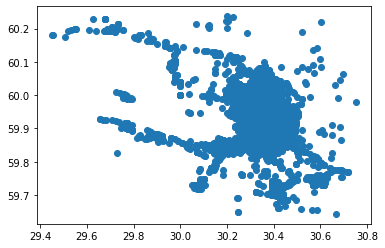

In [14]:
# строим карту записей: видно, что охвачен почти весь город

x = result[['point_lat', 'point_long']].round(4)
# transformer = Normalizer().fit(x)
# normalized = transformer.transform(x)
plt.scatter(x['point_long'], x['point_lat'])

In [ ]:
time = [int(t[:2]) for t in time]

[Text(0.5, 1.0, 'Crashes per hour'),
 Text(0.5, 0, 'Hour'),
 Text(0, 0.5, 'Total count')]

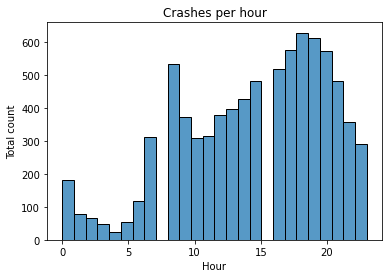

In [37]:
# график количества ДТП в разное время (округлено до часов): к вечеру их число возрастает
sns.histplot(data=time).set(title='Crashes per hour', xlabel='Hour', ylabel='Total count')

[Text(0.5, 1.0, 'Week statistic'),
 Text(0.5, 0, 'Hour of week'),
 Text(0, 0.5, 'Total count')]

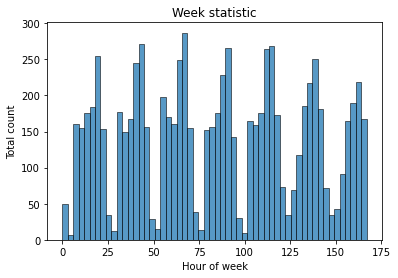

In [42]:
# недельная статистика ДТП: по выходным в среднем аварий меньше, но выделяются ночи пт/сб и вс/пн

daily_stat = [cutted[cutted.day == x] for x in range(7)]
daily_time = np.zeros(len(day))
for i in range(len(day)):
    daily_time[i] = time[i] + day[i]*24
sns.histplot(data=daily_time, bins=8*7).set(title='Week statistic', 
                                            xlabel='Hour of week', ylabel='Total count')